In [1]:
!pip install os
!pip install yfinance
import yfinance as yf
import pandas as pd
import os

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,0,0
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0,0
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0,0
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0,0
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,0,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,0,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,0,0


In [3]:
sp500 = sp500.drop(['Dividends','Stock Splits'], axis = 1)
sp500

,Open,High,Low,Close,Volume
Date,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000
...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000


In [4]:
sp500['tomorrow'] = sp500['Close'].shift(periods= -1, axis=0)
sp500

,Open,High,Low,Close,Volume,tomorrow
Date,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,16.850000
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,16.930000
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,16.980000
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,17.080000
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,17.030001
...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893


In [5]:
sp500['target'] = (sp500['Close'] < sp500['tomorrow']).astype(int)
sp500

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,16.850000,1
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,16.930000,1
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,16.980000,1
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,17.080000,1
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,17.030001,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


In [6]:
import datetime as dt
sp500.index = sp500.index.astype('datetime64[ns]')
sp500 = sp500.copy()[sp500.index.year >= 1990]
sp500

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


In [7]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators= 100,random_state = 1, min_samples_split=100)
#train/test = 80/20
train = sp500.copy().iloc[:round(sp500.shape[0]*0.8)]
test = sp500.copy().iloc[round(sp500.shape[0]*0.8):]
train

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2015-11-16,2022.079956,2053.219971,2019.390015,2053.189941,3741240000,2050.439941,0
2015-11-17,2053.669922,2066.689941,2045.900024,2050.439941,4427350000,2083.580078,1
2015-11-18,2051.989990,2085.310059,2051.989990,2083.580078,3926390000,2081.239990,0


In [8]:
test

,Open,High,Low,Close,Volume,tomorrow,target
Date,,,,,,,
2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3587980000,2089.139893,1
2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3884930000,2088.870117,0
2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2852940000,2090.110107,1
2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1466840000,2080.409912,0
2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4275030000,2102.629883,1
...,...,...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000,4023.889893,1


In [9]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
train_tg = train['target']
train_col = train.copy().drop(['tomorrow','target'],axis=1)
test_tg = test['target']
test_col = test.copy().drop(['tomorrow','target'],axis=1)
rf.fit(train_col,train_tg)
predict = rf.predict(test_col)
predict = pd.Series(predict, index = test.index)
confusion = confusion_matrix(test_tg,predict)
confusion

array([[688,  47],
       [833,  63]], dtype=int64)

In [10]:
test_col

,Open,High,Low,Close,Volume
Date,,,,,
2015-11-23,2089.409912,2095.610107,2081.389893,2086.590088,3587980000
2015-11-24,2084.419922,2094.120117,2070.290039,2089.139893,3884930000
2015-11-25,2089.300049,2093.000000,2086.300049,2088.870117,2852940000
2015-11-27,2088.820068,2093.290039,2084.129883,2090.110107,1466840000
2015-11-30,2090.949951,2093.810059,2080.409912,2080.409912,4275030000
...,...,...,...,...,...
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000
2022-05-12,3903.949951,3964.800049,3858.870117,3930.080078,4964130000


In [11]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(test_tg,predict)

(array([0.45233399, 0.57272727]),
 array([0.93605442, 0.0703125 ]),
 array([0.60992908, 0.12524851]),
 array([735, 896], dtype=int64))

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(test_tg,predict)

0.46045370938074803

In [13]:
from sklearn.metrics import precision_score
precision_score(test_tg,predict)

0.5727272727272728

In [14]:
from sklearn.metrics import recall_score
recall_score(test_tg,predict)

0.0703125

In [15]:
combined = pd.concat([test_tg,predict],axis=1)
combined

,target,0
Date,,
2015-11-23,1,1
2015-11-24,0,1
2015-11-25,1,1
2015-11-27,0,0
2015-11-30,1,1
...,...,...
2022-05-10,0,0
2022-05-11,0,0
2022-05-12,1,0


<AxesSubplot:xlabel='Date'>

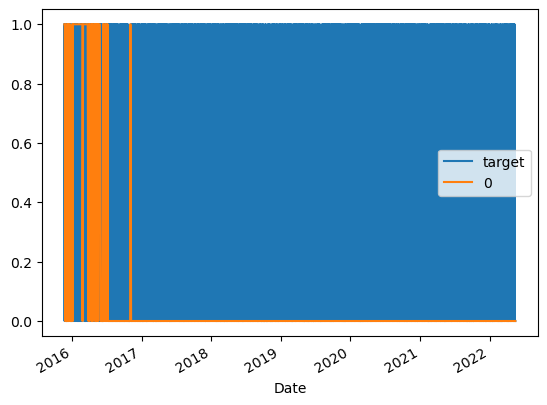

In [16]:
combined.plot()

In [17]:
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['target'])
    predict = model.predict(test[predictors])
    predict = pd.Series(predict, index = test.index, name= 'predictions')
    combined = pd.concat([test['target'], predict], axis= 1)
    return combined

In [18]:
import numpy as np
def backtest(data, model, predictors, start=2500, step = 250): #assume 1 year = 250 days trade start at 10 years and plus 1 year over
    all_predictions  = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)
predictors = ['Open','High','Low','Close','Volume']
predict = backtest(sp500,rf,predictors)

In [19]:
predict['predictions'].value_counts()

0    3305
1    2352
Name: predictions, dtype: int64

In [20]:
precision_score(predict['target'],predict['predictions'])

0.5314625850340136

In [21]:
predict['target'].value_counts() / predict.shape[0]

1    0.536857
0    0.463143
Name: target, dtype: float64

In [22]:
# generate another predictors
horizons = [2,5,60,250,1000]
for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean()
    ratio_column = f'close_ratio_{horizon}'
    sp500[ratio_column] = sp500['Close'] / rolling_avg['Close']
    trend_column = f'trend_{horizon}'
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['target']
predictors = [ratio_column,trend_column]

In [23]:
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,tomorrow,target,close_ratio_2,trend_2,close_ratio_5,trend_5,close_ratio_60,trend_60,close_ratio_250,trend_250,close_ratio_1000,trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-09,4081.270020,4081.270020,3975.479980,3991.239990,4746120000,4001.050049,1,0.983721,0.0,0.962343,2.0,0.914756,26.0,0.898738,132.0,1.158960,553.0
2022-05-10,4035.179932,4068.820068,3958.169922,4001.050049,4630150000,3935.179932,0,1.001227,1.0,0.972892,2.0,0.918469,27.0,0.901037,132.0,1.161381,553.0
2022-05-11,3990.080078,4049.090088,3928.820068,3935.179932,4683220000,3930.080078,0,0.991700,1.0,0.974166,1.0,0.904963,27.0,0.886394,131.0,1.141860,553.0


In [24]:
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['target'])
    predict = model.predict_proba(test[predictors])[:,1]
    predict[predict >= 0.6] = 1
    predict[predict < 0.6] = 0
    predict = pd.Series(predict, index = test.index, name= 'predictions')
    combined = pd.concat([test['target'], predict], axis= 1)
    return combined

In [25]:
model = RandomForestClassifier(n_estimators= 100,random_state = 1, min_samples_split=100)
prediction = backtest(sp500, model, predictors)

In [26]:
prediction['predictions'].value_counts()

0.0    3517
1.0    1139
Name: predictions, dtype: int64

In [27]:
precision_score(prediction['target'],prediction['predictions'])

0.5100965759438104